In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_cat import char_func_cat

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.interpolate import interp2d

In [4]:
def load_data_no_average(path: str, file_end: str, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end)]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        df = h5py.File(fps[kk], "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0]
        y = data["y"][0, :, 0]
        dt = df.attrs['decay_time']
        thresh = -6.687025253601604e-06
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x), len(y)) * 2 - 1
        dg.append(double_ps_g)
        de.append(double_ps_e)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    rows = 1
    cols = len(decay_times)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    # for i in range(rows):
    for j in range(cols):
        
        axes[0].pcolormesh(x, x, np.nanmean(dd[str(1000)][:, :], axis = 0), cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
        axes[0].set_aspect("equal")
        axes[0].set_title(str(1000))     
        axes[1].pcolormesh(x, x, np.nanmean(dd[str(16000)][:, :], axis = 0), cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
        axes[1].set_aspect("equal")
        axes[1].set_title(str(16000))     
    plt.show()
    return dd, decay_times, x, y 
    
def bootstrap_resample(X):
    n = shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(shape(X)[1]):
        for y in range(shape(X)[2]):
                      
                X_resample[:][y][x] = XT[y][x][resample_i]
    return X_resample.T
    
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def cut_indexes(y_inter,angle):
    k = np.tan(angle)
    max_y_index = np.max(y_inter) # define maximal y_index allowed
    max_x_index = max_y_index
    xvec_fine = np.linspace(0, max_x_index, len(y_inter))
    for i, x in enumerate(xvec_fine):
        if np.abs(x*k)>max_y_index:
            max_x_index = xvec_fine[i-1]
            break
    x_indicies = np.linspace(-max_x_index, max_x_index, len(y_inter))
    y_indicies = x_indicies*k
    return x_indicies, y_indicies
    


def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))

In [5]:
# quick comment on plot error handling. introduced flag that is set to true if there is a plotting error. this will result in skipping the rest of the code and the reptition in which the error happend is not taken into account.


def extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, n_reps, plot=False, bootstrap=True, p0_angles =[0, 0, 0, 0, 0, 0, 0,0,0,0],initial_guess_3gaussian = [0,0,0,0,0,0,0,0,0], bounds =([-np.inf, -3.5, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, 2.5, -np.inf ],[np.inf,-2.5, 1.2,np.inf, np.inf, 1.2,np.inf, 3.5, 1.1 ])):
    blob_amps = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_amps[str(decay_times[n])] = []
            
    blob_angle = {}
        # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            blob_angle[str(decay_times[n])] = []

    data_dict = dd
    for rep in range(n_reps):
        plot_error = False
        temp_blob_angle = blob_angle
        if bootstrap:
            dd_bt = {}
            # resample data and saved resampled data in new dictionary
            for j in range(len(decay_times)):
                dd_bt[str(decay_times[j])] = bootstrap_resample(dd[str(decay_times[j])])
            data_dict = dd_bt
        
        if plot:
            fig, axs = plt.subplots(4, len(decay_times), figsize = (16, 20), sharey="row",)

        p0_angles = p0_angles
        popts = []
        angles = []
        print("Run Number:", rep)
        for i, time in enumerate(decay_times):
            
            scaling = 3
            xvec = x*scaling # i define it like this in case i want to slice x
            yvec = x*scaling
            X, Y = np.meshgrid(yvec, xvec)

            #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
            initial_guess = (0.8,  0.8, 1, 1, p0_angles[i], -0.08301675) # upper blob
            data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
            try:
                popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
                popts.append(popt)
                angles.append(popt[4])
                blob_angle[str(time)].append(popt[4])

                data_fitted1 = char_func_cat((X, Y), *popt)
                if plot:
                    axs[0][i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
                    axs[0][i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
                    axs[0][i].set_aspect("equal")
                    axs[0][i].set_title(str(decay_times[i]))
                    
            except RuntimeError:
                print(f"Runtime Error occured trying to fit cat in repetition {rep} for time {time}. Move on to next repetition")
                plot_error = True

    
        
        
        if not plot_error:
            cut_array = []
            for i, time in enumerate(decay_times):
                data = np.nanmean(data_dict[str(decay_times[i])], axis = 0)
                angle = angles[i]
                if np.abs(angles[i])<np.deg2rad(15):
                    data =  np.nanmean(data_dict[str(decay_times[i])], axis = 0).T
                    angle = np.pi/2-angles[i]
                #interpolate data
                func = interp2d(xvec,yvec,data, kind="cubic")
                # define finer x,y arrays with same end values as data x,y
                x_inter = np.linspace(np.min(xvec),np.max(xvec), 3000)
                y_inter = np.linspace(np.min(xvec),np.max(xvec), 3000)
                
                # get x and y indicies for line cut and load the line cut in cut
                x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
                cut = []
                for j in range(len(x_index)):
                    cut.append(float(func(x_index[j],y_index[j])))
                cut_array.append(cut)
                if plot:
                    axs[1][i].set_aspect("equal")
                    axs[1][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
                    axs[1][i].scatter(x_index, y_index, c='k', marker = '.')
                    axs[1][i].set_title(str(decay_times[i]))
                    axs[2][i].plot(x_inter,cut)


            
            fit_amp_cat = []
            fit_amp_std_cat = []
            for i, cut in enumerate(cut_array):
                
                
                x_cut = np.array(x_inter)
                y_cut = np.array(cut)
                
                y0 = gauss_3(x, *initial_guess_3gaussian)

                try:
                    popt, pcov = curve_fit(gauss_3, x_cut, y_cut, p0=initial_guess_3gaussian, bounds=bounds,maxfev = 5000)
                    blob_amps[str(decay_times[i])].append((popt[0]+popt[6])/2)
                    if plot:
                        axs[3][i].plot(x_cut, y_cut, 'b', label="given curve")
                        axs[3][i].plot(x_cut, gauss_3(x_cut, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
                        for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
                            axs[3][i].plot(x_cut, gauss_1(x_cut, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
                        axs[3][i].legend()
                        axs[3][i].autoscale(axis='x', tight=True)
            
                
                except RuntimeError:
                    print(f"RuntimeError ocurred during triple gaussian fit in rep {rep} for time{decay_times[i]}" )
                    plot_error = True
                    blob_angle = temp_blob_angle # forget any change done to blob angle in this round
                    continue
    if plot:
            plt.tight_layout()
            plt.show()
               
    return blob_amps, blob_angle


# only use this function if n_reps is high enough! might lead to error for lower values
# filtering out data with wrong fitting angle
def find_averaged_amps_and_errorbars(decay_times, blob_amps, blob_angle):
    blob_amps_averaged = []
    error_bars = []
    for time in decay_times:
        blobbies = np.array(blob_amps[str(time)])
        blobbies = blobbies[blobbies<0.5] # filter all blobs with amp larger 0.5, as they are unphysical and plotting errors.
        # # make sure angles has same length as blob_amps for every time
        # angles = np.array(blob_angle[str(time)])[:len(blob_amps[str(time)])]
        # # only keep the blob_amp values, for which the angle is withhin one std of the mean angle value. 
        # blobbies[str(time)] = np.array(blob_amps[str(time)])[np.abs((angles-np.mean(angles)))<np.std(angles)]
        
        blob_amps_averaged.append(np.mean(blobbies))
        error_bars.append(np.std(blobbies))
        
    return blob_amps_averaged, error_bars

        

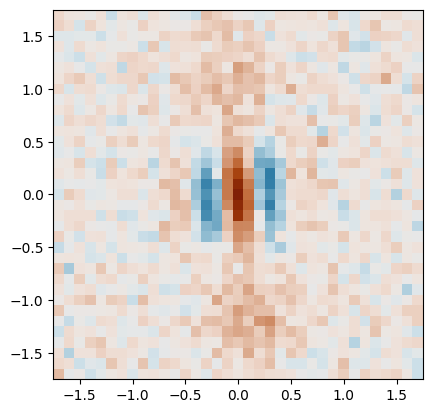

In [10]:
import cmcrameri.cm as cmc
data_new = bootstrap_resample(dd['16000'])
fig, axes = plt.subplots()
axes.set_aspect("equal")
axes.pcolormesh(x, x, np.nanmean(data_new, axis = 0), cmap="cmc.vik", vmin = -1 , vmax = 1) 


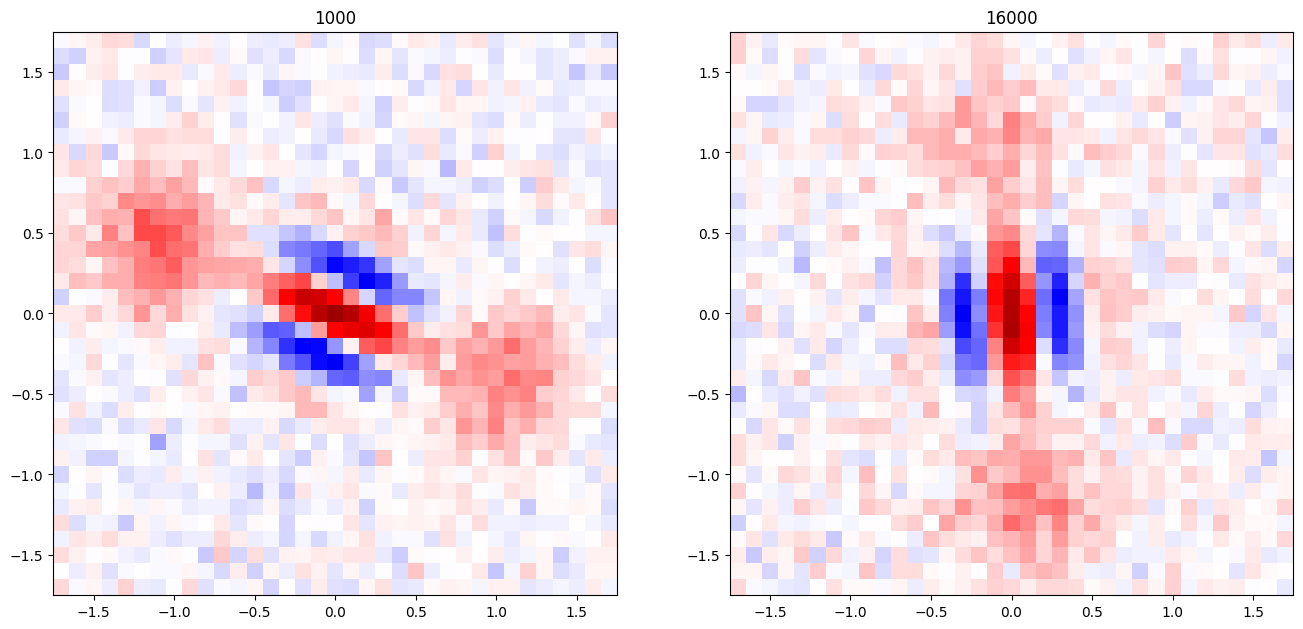

In [7]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = 'cat_decay.h5'
dd, decay_times, x, y = load_data_no_average(path, file_end)

amp1 = 0.4
sigma1 = 1
cen1 = -3.6
amp2 = 0.8
sigma2 = 1
cen2 = 0
amp3 = 0.4
cen3 = 3.6
sigma3 = 1      
initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
angles = [1.68, 1.96, 1.35, 3.02, 0.68, 3.16, 2.465, 1.47, 2.97, 1.16]

bounds =[-np.inf, -3.8, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, 2.9, -np.inf ],[np.inf,-3, 1.2 ,np.inf, np.inf, 1.1 ,np.inf, 4, 1.2]


In [17]:
decay_times = [1000,16000]

Run Number: 0


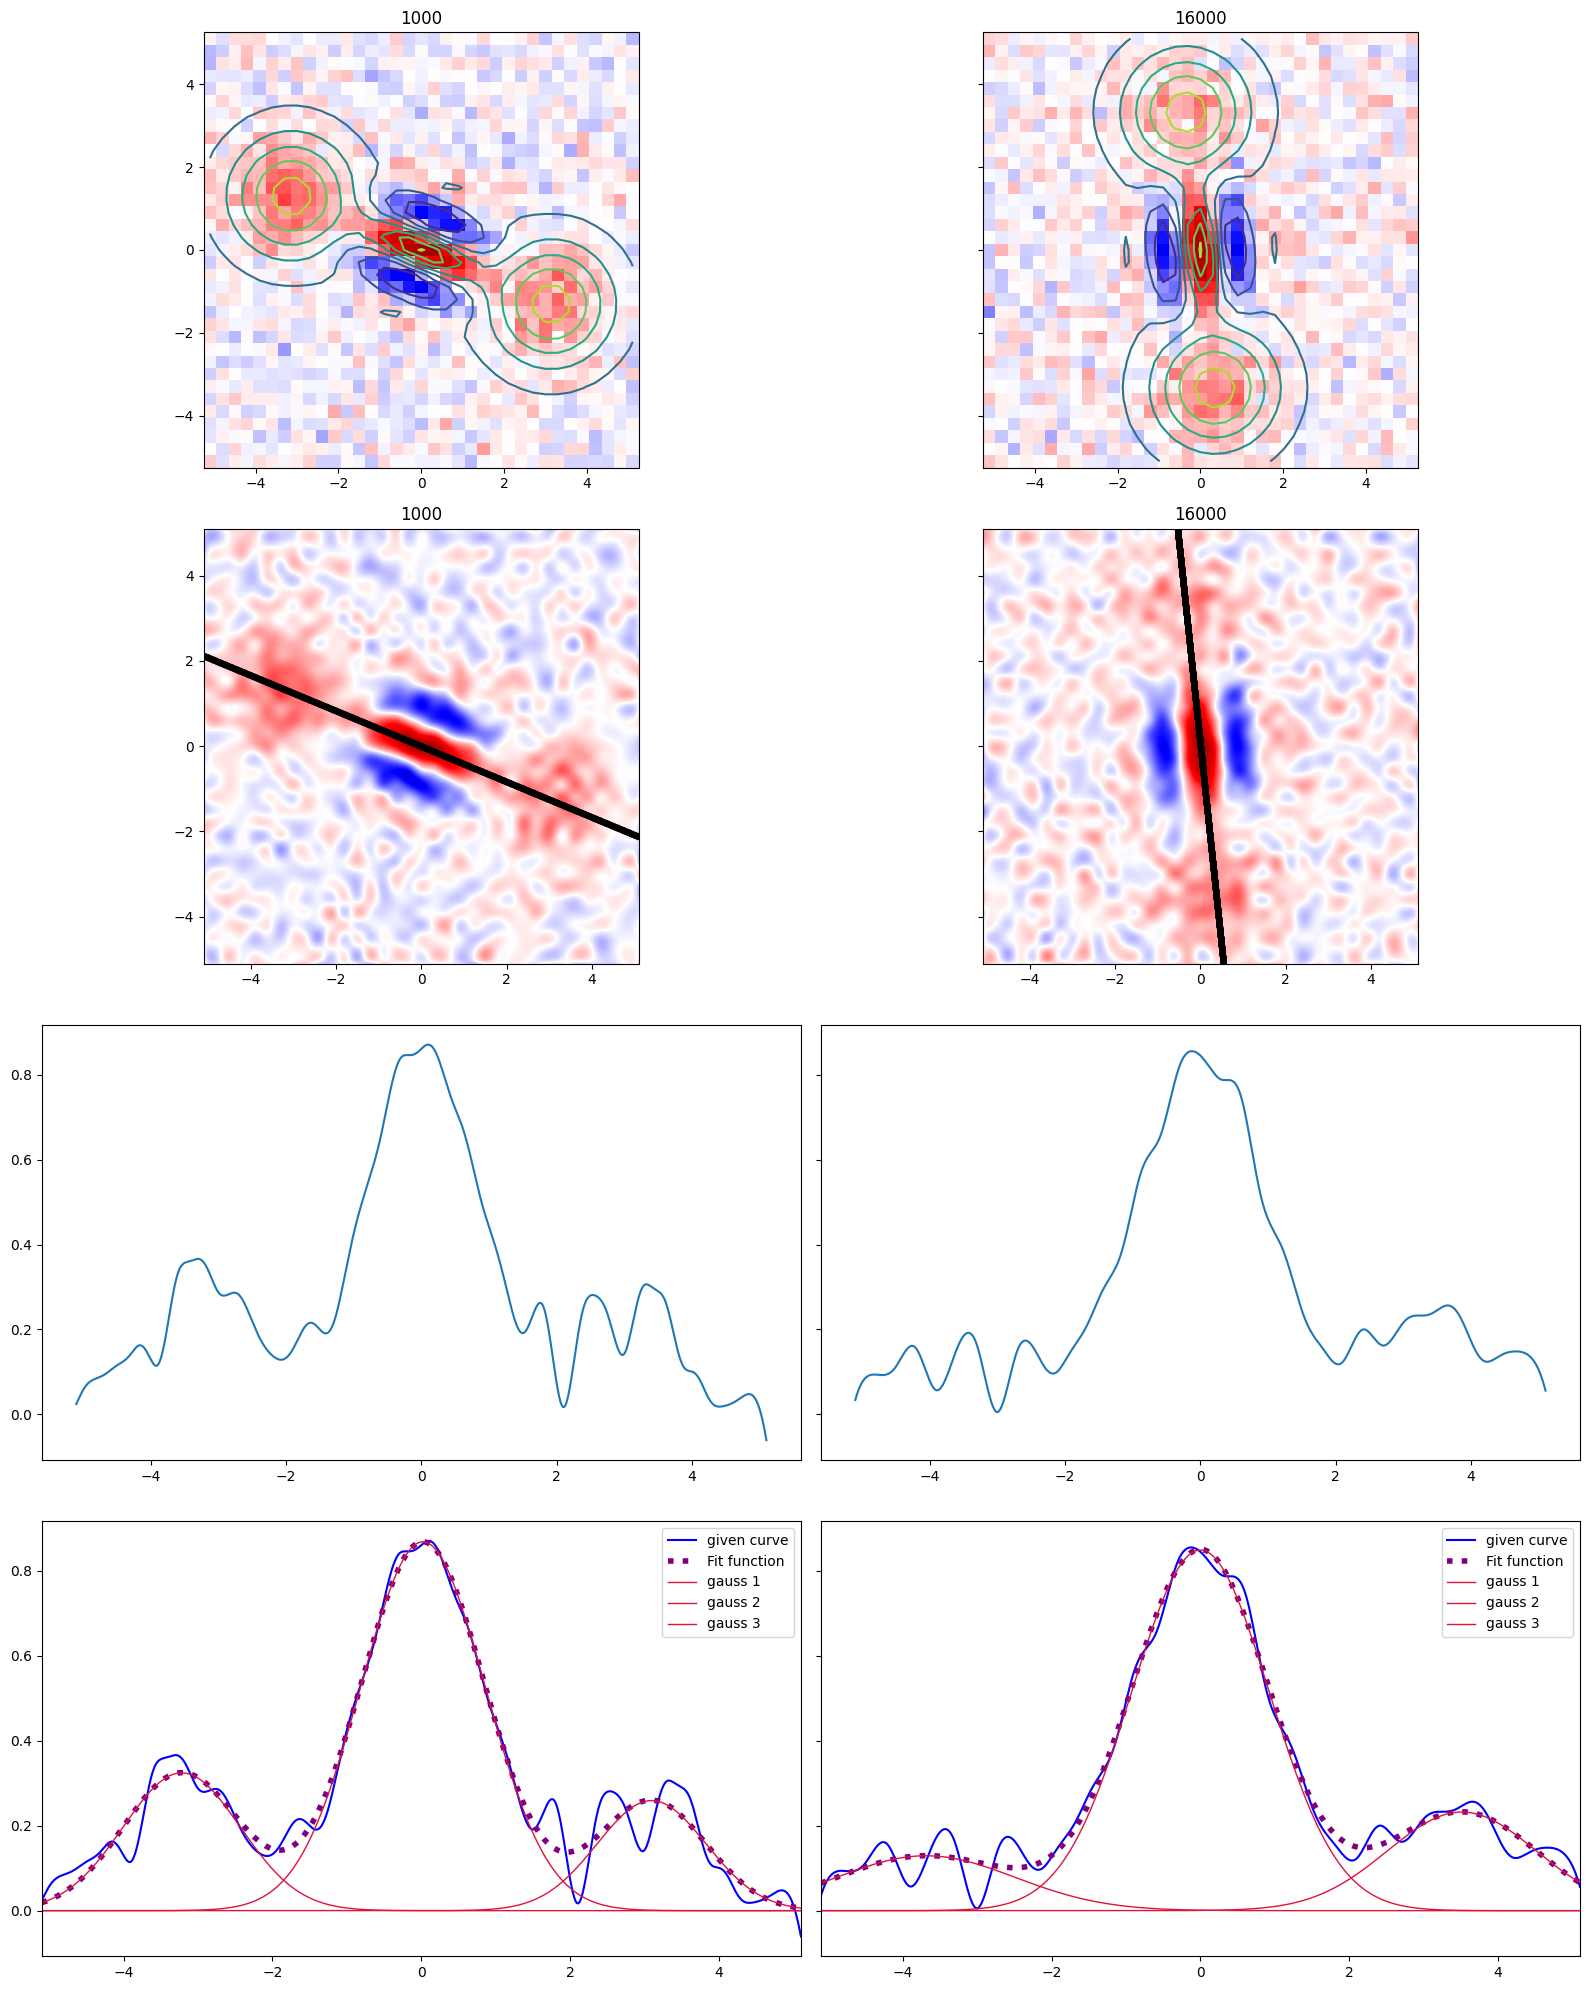

Text(0, 0.5, 'Side Blob Amp')

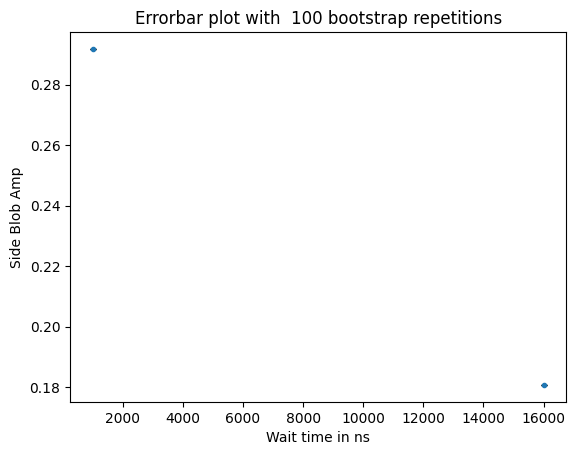

In [18]:
cat_blob_amps, cat_blob_angle = extract_blob_amplitudes_bootstrap(dd, decay_times, x, y, 1, p0_angles=angles, initial_guess_3gaussian=initial_guess, plot=True, bounds=bounds)

cat_blob_amps_averaged , cat_error_bars = find_averaged_amps_and_errorbars(decay_times, cat_blob_amps, cat_blob_angle)

plt.errorbar(decay_times[:], cat_blob_amps_averaged[:],yerr=cat_error_bars[:],fmt= '.', ecolor = 'k', capsize = 2)
plt.title(f'Errorbar plot with  100 bootstrap repetitions')
plt.xlabel('Wait time in ns')
plt.ylabel("Side Blob Amp")